# Model Predictive Control

An entire marathon! Trying to make model predictive control (slightly more advanced than LQG) work. Main reference: https://ieeexplore-ieee-org.libproxy.berkeley.edu/stamp/stamp.jsp?tp=&arnumber=8511551

Steps:

1. Keck mirror finite-element analysis: find its $\omega_D, \omega_T, d$. Will just skip over this. 
2. Convert TF to SS and augment to make $C_i, B_i$.
3. Augment with turbulence and vibrations to make $A_i$ and $C_0$.
4. Pick $R_y, R_u, u_{max}$.
5. Solve the quadratic system!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, io, linalg
from cvxopt import solvers, matrix

from aberrations import *
from observer import *
from controller import *
from fractal_deriv import design_filt
from utils import *

f_sampling = 1000
rms = lambda data: np.sqrt(np.mean(data ** 2))
eps = 1e-8
process_noise = 0.01
measurement_noise = 0.06

N_delay = 2

In [2]:
# step 1: Keck mirror FEA results.

# These are completely random numbers. 

w_TT = 100
z_TT = 1

def make_impulse(w, z, T=np.arange(0, 1, 0.001)):
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

num, den = signal.cont2discrete(([w_TT ** 2], [1, 2 * w_TT * z_TT, w_TT ** 2]), dt=1/f_sampling)[:2]
A_TT, B_TT, C_TT, D_TT = signal.tf2ss(num, den)

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [3]:
size = 5000
N_vibe = 1
params = make_vibe_params(N=N_vibe)
vibe = make_1D_vibe_data(steps=size, N=N_vibe) + np.random.normal(0, process_noise * N_vibe, (size,))
pol = vibe
variances = np.array([process_noise] * N_vibe)
kfilter_vibe = make_kfilter_vibe(np.vstack((params[1:3])).T, variances)

Took 8 iterations to get steady-state covariance.


In [4]:
res, phy = kfilter_vibe.run(vibe + np.random.normal(0, measurement_noise, vibe.size), save_physics=True)

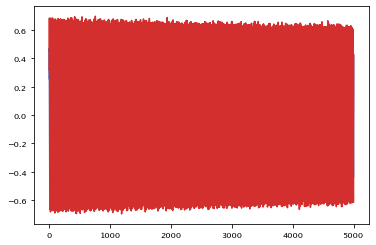

In [5]:
plt.plot(res)
plt.plot(vibe)

In [6]:
N = 2 * N_vibe + N_delay + 1

In [7]:
A = np.zeros((N, N))
for i in range(2 * N_vibe):
    for j in range(2 * N_vibe):
        A[i][j] = kfilter_vibe.A[i][j]
        
for i in range(N_vibe):
    A[2 * N_vibe][2 * i] = 1
    A[2 * N_vibe][2 * i + 1] = -1
    
A[2 * N_vibe][2 * N_vibe] = 1
for i in range(N_delay):
    A[2 * N_vibe + i + 1][2 * N_vibe + i] = 1

In [8]:
A

array([[-0.08881857, -0.99991376,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ]])

In [9]:
B = np.zeros((N,1))
B[2 * N_vibe] = 1
C = np.zeros((1,N))
C[0][0] = 1
C[0][1] = -1
C[0][3] = 1

Q = np.zeros((N,N))
for i in range(N_vibe):
    Q[2 * i][2 * i] = variances[i]

R = np.array([measurement_noise])

In [10]:
kfilter = KFilter(np.zeros(N,), A, B, Q, C, R, has_input=True)

Took 36 iterations to get steady-state covariance.


In [11]:
N_frames = 5
y, u = 1, 25
R_y = np.identity(N_frames) * y
R_u = np.identity(N_frames) * u
C_0 = np.vstack(([kfilter.H] + [kfilter.H.dot(kfilter.A ** i) for i in range(1, N_frames)]))
D_0 = np.zeros((N_frames,N_frames))
for i in range(N_frames):
    for j in range(i):
        if i - j - 1 == 0:
            D_0[i][j] = kfilter.H.dot(kfilter.B)
        else:
            D_0[i][j] = kfilter.H.dot(kfilter.A ** (i - j - 1)).dot(kfilter.B)

In [18]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
H3 = D_0.dot(R_y).dot(D_0.T) + R_u
u_max = 5 * float(max(np.diff(pol[:5000])))
G = np.identity(N_frames)
G = np.vstack((np.identity(N_frames), -np.identity(N_frames)))
h = np.vstack([u_max] * (2 * N_frames))

In [19]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
delay = 2

shifts = np.diff(pol)
res_control = np.zeros(pol.shape)
res_control[0] = pol[0]
residual = 

actions = np.zeros(pol.shape)
for i in range(size):
    try:
        if i > 0:
            res_control[i] = res_control[i - 1] + shifts[i - 1] + actions[i - 1]
        measurement = res_control[i - delay] + np.random.normal(0, 0.06)
        kfilter.update(measurement)
        
        if i < pol.size - N_frames - 1 and i % N_frames == 0:
            H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
            print(kfilter.state)
            solvers.options['show_progress'] = False
            solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='cvxopt')['x']
            print(solution)
            for j in range(i, i + N_frames):
                actions[j] = solution[j - i]
        
        kfilter.predict(actions[i - 1])
        
        
    except:
        print(i)
        raise

[ 0.01494655 -0.03295545 -0.03295545 -0.00089159  0.02251218]
[ 1.41e-02]
[ 7.66e-03]
[ 6.24e-03]
[-2.16e-04]
[-2.07e-04]

[ 0.17912561  0.02245047  0.05025844 -0.07389425  0.02119652]
[ 2.90e-02]
[ 2.06e-02]
[ 8.21e-03]
[-2.84e-04]
[-2.73e-04]

[-0.21111454  0.08530144  0.17048211  0.2058728   0.00670608]
[-9.83e-02]
[-6.11e-02]
[-3.60e-02]
[ 1.24e-03]
[ 1.20e-03]

[ 0.14300971 -0.16650514 -0.27570706 -0.17123184  0.05149767]
[ 1.14e-01]
[ 6.70e-02]
[ 4.51e-02]
[-1.56e-03]
[-1.50e-03]

[-0.09246609  0.05798635  0.17427767  0.17953613  0.04964965]
[-6.86e-02]
[-4.27e-02]
[-2.50e-02]
[ 8.66e-04]
[ 8.33e-04]

[ 0.0210413  -0.03717381 -0.05784546 -0.05034487  0.00243244]
[ 2.19e-02]
[ 1.26e-02]
[ 8.95e-03]
[-3.09e-04]
[-2.98e-04]

[ 0.1241905   0.01095935  0.03427724 -0.03830604  0.03579856]
[ 2.06e-02]
[ 1.44e-02]
[ 6.09e-03]
[-2.11e-04]
[-2.02e-04]

[-0.21905455  0.05096801  0.11488996  0.18276819  0.0068798 ]
[-8.41e-02]
[-5.34e-02]
[-2.97e-02]
[ 1.03e-03]
[ 9.87e-04]

[ 0.17203725 -0.

[-4.17e-02]
[-2.60e-02]
[-1.52e-02]
[ 5.27e-04]
[ 5.07e-04]

[ 0.18183766 -0.10684652 -0.20916721 -0.18072322  0.00135886]
[ 1.02e-01]
[ 6.26e-02]
[ 3.84e-02]
[-1.33e-03]
[-1.28e-03]

[-0.16861115  0.12048904  0.22059083  0.18784224 -0.02493249]
[-1.03e-01]
[-6.23e-02]
[-3.93e-02]
[ 1.36e-03]
[ 1.31e-03]

[ 0.09980586 -0.05341393 -0.15776246 -0.16315194 -0.03229293]
[ 6.60e-02]
[ 4.12e-02]
[ 2.40e-02]
[-8.29e-04]
[-7.97e-04]

[-0.02149511  0.07765258  0.10501012  0.04486348 -0.02748584]
[-3.66e-02]
[-2.02e-02]
[-1.57e-02]
[ 5.44e-04]
[ 5.23e-04]

[-0.1022217  -0.04062813 -0.08606769  0.01911388 -0.03804312]
[-5.68e-04]
[-2.59e-03]
[ 1.89e-03]
[-6.52e-05]
[-6.27e-05]

[ 0.18851443 -0.03712822 -0.08338108 -0.14623833  0.00223057]
[ 6.81e-02]
[ 4.35e-02]
[ 2.38e-02]
[-8.24e-04]
[-7.92e-04]

[-0.16108583  0.11222966  0.20054916  0.15859459 -0.04155146]
[-9.57e-02]
[-5.79e-02]
[-3.65e-02]
[ 1.26e-03]
[ 1.21e-03]

[ 0.11645803 -0.11630682 -0.2176029  -0.14985425  0.02155622]
[ 8.94e-02]
[ 5.

[ 6.89e-02]
[ 4.26e-02]
[ 2.54e-02]
[-8.80e-04]
[-8.46e-04]

[-0.21159987  0.04697482  0.14337342  0.22280975  0.01541786]
[-8.88e-02]
[-5.68e-02]
[-3.10e-02]
[ 1.07e-03]
[ 1.03e-03]

[ 0.20843218 -0.05914761 -0.13915501 -0.22886668 -0.00071625]
[ 8.80e-02]
[ 5.56e-02]
[ 3.14e-02]
[-1.08e-03]
[-1.04e-03]

[-0.08298176  0.12375222  0.21871219  0.15426483 -0.03816748]
[-8.23e-02]
[-4.83e-02]
[-3.28e-02]
[ 1.13e-03]
[ 1.09e-03]

[-0.0678008  -0.02625971 -0.09454714 -0.02756921 -0.04208263]
[ 8.56e-03]
[ 4.28e-03]
[ 4.09e-03]
[-1.41e-04]
[-1.36e-04]

[ 0.09242385 -0.0332251  -0.08364103 -0.08957579  0.01863014]
[ 4.49e-02]
[ 2.82e-02]
[ 1.61e-02]
[-5.58e-04]
[-5.37e-04]

[-0.1920999   0.00979898  0.04786329  0.14693967 -0.00115428]
[-5.83e-02]
[-3.84e-02]
[-1.93e-02]
[ 6.66e-04]
[ 6.40e-04]

[ 0.23126228 -0.09015028 -0.16788544 -0.22062431  0.01985097]
[ 1.03e-01]
[ 6.39e-02]
[ 3.77e-02]
[-1.30e-03]
[-1.25e-03]

[-0.13948627  0.10285923  0.22893935  0.21513961  0.01260254]
[-9.66e-02]
[-5.

[ 8.11e-02]
[ 5.07e-02]
[ 2.94e-02]
[-1.02e-03]
[-9.77e-04]

[-0.07340099  0.08380655  0.14332615  0.11066854 -0.01245915]
[-5.87e-02]
[-3.47e-02]
[-2.32e-02]
[ 8.01e-04]
[ 7.70e-04]

[-0.05215986 -0.02411804 -0.08130444 -0.02946097 -0.0504021 ]
[ 8.95e-03]
[ 4.66e-03]
[ 4.11e-03]
[-1.42e-04]
[-1.37e-04]

[ 0.09255108  0.00096596 -0.03787033 -0.05889757 -0.03235921]
[ 3.12e-02]
[ 2.09e-02]
[ 9.98e-03]
[-3.45e-04]
[-3.32e-04]

[-0.19689605  0.11020348  0.13291155  0.12623123 -0.0960091 ]
[-8.79e-02]
[-5.28e-02]
[-3.39e-02]
[ 1.17e-03]
[ 1.13e-03]

[ 0.18720867 -0.10855972 -0.25957417 -0.24368199 -0.02653951]
[ 1.16e-01]
[ 7.15e-02]
[ 4.28e-02]
[-1.48e-03]
[-1.42e-03]

[-0.13459558  0.08963193  0.16838732  0.1621862  -0.02468192]
[-7.98e-02]
[-4.85e-02]
[-3.03e-02]
[ 1.05e-03]
[ 1.01e-03]

[-0.00720835 -0.09757806 -0.17776676 -0.06216627  0.00720239]
[ 4.87e-02]
[ 2.73e-02]
[ 2.07e-02]
[-7.15e-04]
[-6.87e-04]

[ 0.09703881  0.02505863  0.04186957 -0.03716777  0.00970337]
[ 1.12e-02]
[ 8.

[-0.13950165  0.08170565  0.2153514   0.1989027   0.02667001]
[-9.16e-02]
[-5.68e-02]
[-3.37e-02]
[ 1.16e-03]
[ 1.12e-03]

[ 0.12957374 -0.05444876 -0.10262434 -0.1170467   0.00136445]
[ 6.00e-02]
[ 3.72e-02]
[ 2.21e-02]
[-7.64e-04]
[-7.35e-04]

[-0.08401764  0.05588802  0.12733784  0.14283736  0.0266754 ]
[-5.51e-02]
[-3.38e-02]
[-2.06e-02]
[ 7.13e-04]
[ 6.85e-04]

[-0.01764198 -0.03490944 -0.07305828 -0.05026328 -0.01319126]
[ 1.61e-02]
[ 8.87e-03]
[ 6.97e-03]
[-2.41e-04]
[-2.32e-04]

[ 0.15688464 -0.00105386 -0.00682528 -0.09423387  0.02082652]
[ 3.93e-02]
[ 2.62e-02]
[ 1.27e-02]
[-4.39e-04]
[-4.22e-04]

[-0.17543653  0.12044     0.19218946  0.14962462 -0.04834922]
[-9.78e-02]
[-5.88e-02]
[-3.76e-02]
[ 1.30e-03]
[ 1.25e-03]

[ 0.13036758 -0.10869629 -0.2302951  -0.17548838  0.00277754]
[ 9.52e-02]
[ 5.77e-02]
[ 3.62e-02]
[-1.25e-03]
[-1.20e-03]

[-0.10967016  0.06647361  0.13395887  0.13214451 -0.00245974]
[-6.37e-02]
[-3.90e-02]
[-2.39e-02]
[ 8.27e-04]
[ 7.95e-04]

[ 0.03204104 -0.

[ 0.20669555 -0.12200654 -0.22289485 -0.21181931  0.01950473]
[ 1.13e-01]
[ 6.87e-02]
[ 4.25e-02]
[-1.47e-03]
[-1.41e-03]

[-0.13384908  0.10819947  0.23082485  0.20726245 -0.00628176]
[-9.61e-02]
[-5.84e-02]
[-3.65e-02]
[ 1.26e-03]
[ 1.21e-03]

[ 0.00653685 -0.06830916 -0.13675534 -0.07729914  0.00231246]
[ 3.98e-02]
[ 2.29e-02]
[ 1.63e-02]
[-5.64e-04]
[-5.42e-04]

[ 0.08378298  0.02708742  0.0383834  -0.03933544  0.02611855]
[ 8.68e-03]
[ 7.27e-03]
[ 1.41e-03]
[-4.88e-05]
[-4.70e-05]

[-0.16531678  0.03384425  0.0619108   0.112056   -0.02338384]
[-5.71e-02]
[-3.64e-02]
[-2.01e-02]
[ 6.96e-04]
[ 6.69e-04]

[ 0.16224211 -0.0566603  -0.14158808 -0.17142624 -0.00535596]
[ 7.74e-02]
[ 4.86e-02]
[ 2.78e-02]
[-9.61e-04]
[-9.24e-04]

[-0.16177179  0.08864077  0.15719893  0.15871372 -0.02373667]
[-8.35e-02]
[-5.10e-02]
[-3.14e-02]
[ 1.09e-03]
[ 1.04e-03]

[ 0.07437224 -0.08891803 -0.18622242 -0.13486569 -0.01660376]
[ 6.96e-02]
[ 4.17e-02]
[ 2.70e-02]
[-9.32e-04]
[-8.96e-04]

[ 0.05642488  0.

[ 1.11e-01]
[ 6.83e-02]
[ 4.12e-02]
[-1.42e-03]
[-1.37e-03]

[-0.14296239  0.10674026  0.20184868  0.16766231 -0.02361245]
[-9.12e-02]
[-5.52e-02]
[-3.48e-02]
[ 1.20e-03]
[ 1.16e-03]

[ 0.05035235 -0.07530509 -0.1615686  -0.12470227  0.00034631]
[ 5.69e-02]
[ 3.39e-02]
[ 2.21e-02]
[-7.66e-04]
[-7.36e-04]

[ 0.00980796 -0.02590528  0.00113697  0.04797735  0.05245209]
[ 4.15e-03]
[ 1.39e-03]
[ 2.67e-03]
[-9.22e-05]
[-8.86e-05]

[-0.08811351  0.01302807  0.04744263  0.05826034 -0.00652779]
[-3.35e-02]
[-2.17e-02]
[-1.15e-02]
[ 3.96e-04]
[ 3.81e-04]

[ 0.16425472  0.00519777 -0.02675653 -0.12290848 -0.01063266]
[ 4.53e-02]
[ 3.06e-02]
[ 1.43e-02]
[-4.95e-04]
[-4.76e-04]

[-0.21419088  0.106387    0.16455019  0.19015195 -0.04258853]
[-9.93e-02]
[-6.06e-02]
[-3.74e-02]
[ 1.29e-03]
[ 1.24e-03]

[ 0.08826819 -0.11068894 -0.24901111 -0.1806376  -0.02009275]
[ 8.97e-02]
[ 5.40e-02]
[ 3.45e-02]
[-1.19e-03]
[-1.15e-03]

[-0.06567703  0.06163238  0.10162248  0.08407735 -0.00840805]
[-4.50e-02]
[-2.

[-0.14999559  0.04963488  0.14869084  0.1666248   0.02734047]
[-7.56e-02]
[-4.78e-02]
[-2.69e-02]
[ 9.29e-04]
[ 8.93e-04]

[ 0.15597338 -0.06799077 -0.11868594 -0.12334436  0.02934401]
[ 7.13e-02]
[ 4.40e-02]
[ 2.64e-02]
[-9.14e-04]
[-8.78e-04]

[-0.18604098  0.06622276  0.15714969  0.21482377  0.0134365 ]
[-8.76e-02]
[-5.49e-02]
[-3.16e-02]
[ 1.09e-03]
[ 1.05e-03]

[ 0.05307088 -0.08168869 -0.16459551 -0.12030339 -0.00022509]
[ 5.87e-02]
[ 3.48e-02]
[ 2.31e-02]
[-7.98e-04]
[-7.67e-04]

[0.03586963 0.02333325 0.05733436 0.0239568  0.02633394]
[-7.04e-03]
[-3.43e-03]
[-3.45e-03]
[ 1.19e-04]
[ 1.15e-04]

[-0.13924982  0.02789796  0.0473256   0.08888092 -0.02879393]
[-4.69e-02]
[-2.99e-02]
[-1.65e-02]
[ 5.72e-04]
[ 5.50e-04]

[ 0.19132289 -0.08600288 -0.1592158  -0.18098074  0.03637463]
[ 9.09e-02]
[ 5.61e-02]
[ 3.37e-02]
[-1.16e-03]
[-1.12e-03]

[-0.16628101  0.10396613  0.21079599  0.18944234 -0.01282431]
[-9.87e-02]
[-6.03e-02]
[-3.71e-02]
[ 1.28e-03]
[ 1.23e-03]

[ 0.13868364 -0.05282

[ 0.17987976 -0.09376508 -0.20423261 -0.19972421  0.00563923]
[ 9.96e-02]
[ 6.15e-02]
[ 3.69e-02]
[-1.27e-03]
[-1.23e-03]

[-0.09874136  0.06318891  0.15043117  0.13090289  0.01473766]
[-6.48e-02]
[-3.99e-02]
[-2.41e-02]
[ 8.33e-04]
[ 8.01e-04]

[ 0.06312384 -0.03950234 -0.08141103 -0.08293642 -0.03119246]
[ 3.78e-02]
[ 2.31e-02]
[ 1.42e-02]
[-4.91e-04]
[-4.72e-04]

[0.02227061 0.04802887 0.08156234 0.03339936 0.02200635]
[-1.81e-02]
[-9.49e-03]
[-8.28e-03]
[ 2.86e-04]
[ 2.75e-04]

[-0.13950777  0.00103222 -0.0014653   0.06782463 -0.02468522]
[-3.31e-02]
[-2.21e-02]
[-1.07e-02]
[ 3.71e-04]
[ 3.57e-04]

[ 0.18587662 -0.07015216 -0.13795482 -0.16553713  0.01974162]
[ 8.32e-02]
[ 5.18e-02]
[ 3.04e-02]
[-1.05e-03]
[-1.01e-03]

[-0.141749    0.07304761  0.16997847  0.17262737 -0.00247815]
[-8.06e-02]
[-4.99e-02]
[-2.97e-02]
[ 1.03e-03]
[ 9.86e-04]

[ 0.10725512 -0.07834762 -0.14153159 -0.13182396  0.01593495]
[ 6.59e-02]
[ 3.98e-02]
[ 2.52e-02]
[-8.72e-04]
[-8.39e-04]

[-0.03003486  0.04061

[ 6.46e-02]
[ 4.08e-02]
[ 2.29e-02]
[-7.93e-04]
[-7.63e-04]

[-0.1730617   0.10948433  0.17647902  0.15631877 -0.04053273]
[-9.25e-02]
[-5.59e-02]
[-3.54e-02]
[ 1.22e-03]
[ 1.18e-03]

[ 0.13255394 -0.072238   -0.18866098 -0.20609518 -0.02448625]
[ 8.28e-02]
[ 5.14e-02]
[ 3.03e-02]
[-1.05e-03]
[-1.01e-03]

[-0.03856462  0.05217515  0.10041502  0.09469008 -0.00384231]
[-3.75e-02]
[-2.22e-02]
[-1.47e-02]
[ 5.10e-04]
[ 4.90e-04]

[-0.0944704  -0.01435515 -0.04109946  0.02138987 -0.02137691]
[-1.16e-02]
[-8.54e-03]
[-3.01e-03]
[ 1.04e-04]
[ 1.00e-04]

[ 0.15584034 -0.05250676 -0.10181635 -0.12864807  0.01937856]
[ 6.59e-02]
[ 4.12e-02]
[ 2.39e-02]
[-8.27e-04]
[-7.95e-04]

[-0.15470395  0.09037389  0.17143566  0.14868468 -0.01748155]
[-8.54e-02]
[-5.22e-02]
[-3.21e-02]
[ 1.11e-03]
[ 1.07e-03]

[ 0.13074005 -0.08044795 -0.16879241 -0.14942514 -0.00142697]
[ 7.82e-02]
[ 4.79e-02]
[ 2.93e-02]
[-1.01e-03]
[-9.74e-04]

[-0.09139271  0.07278608  0.1399767   0.13723586 -0.01282357]
[-6.13e-02]
[-3.

In [20]:
rms(pol[kfilter.iters:])

0.4613501724779182

In [21]:
rms(res_control[kfilter.iters:])

0.41799124768633755

(1e-10, 49.513013225649836)

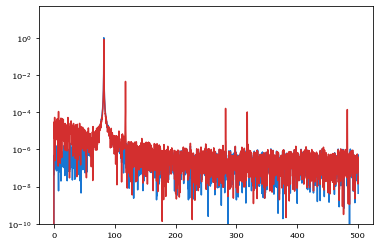

In [22]:
plt.semilogy(*signal.periodogram(pol, fs=f_sampling))
plt.semilogy(*signal.periodogram(res_control, fs=f_sampling))
# plt.semilogy(*signal.periodogram(actions, fs=f_sampling))
plt.ylim(1e-10)

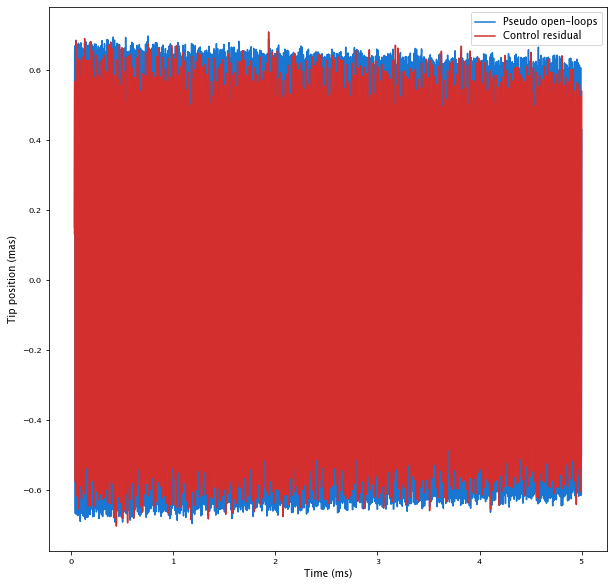

In [23]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), pol[kfilter.iters:], label='Pseudo open-loops')
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), res_control[kfilter.iters:] - np.mean(res_control[kfilter.iters:]), label='Control residual')
plt.xlabel("Time (ms)")
plt.ylabel("Tip position (mas)")
plt.legend()
plt.show()